<center><u><h2>Hybrid Quantum-Classical Neural Network implementation for recognizing hand-written digit recognition</u></h2>
    <h4>Carlos Fernandez ; Sharjeel Ansari</h4></center>

In [1]:
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

from qiskit.circuit import ControlledGate
from qiskit import Aer
import qiskit
import joblib

import numpy as np
from matplotlib import pyplot as plt

from tqdm import tqdm
import itertools

In [2]:
np.random.seed = 42

n_qubits = 3     # Number of qubits required to generate the highest label
n_shots = 1000
shift = np.pi/4  # For gradient descent
learningRate = 0.0009

aerSimulator = Aer.get_backend('qasm_simulator')

In [3]:
# Function to generate bit representation of digits that can be represented with n_qubits qubits.
def createLabels():
    label = []
    L = list(itertools.product([0,1], repeat = n_qubits))
    for l in L:
        label.append(''.join([str(bit) for bit in l]))
    return label

Label = createLabels()
print(Label)

['000', '001', '010', '011', '100', '101', '110', '111']


In [4]:

class QuantumCircuit():
    
    def __init__(self, n_qubits, backend, shots):
        self.n_qubits = n_qubits
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.parameters = {i: qiskit.circuit.Parameter('Theta' + str(i)) for i in range(n_qubits)}
        
        all_qubits = [i for i in range(n_qubits)]
        self.circuit.h(all_qubits)
        self.circuit.barrier()
        
        for i in range(n_qubits):
            self.circuit.ry(self.parameters[i], i)
        
        self.circuit.measure_all()
        self.backend = backend
        self.shots = shots
    
    def expectationZ(self, counts, shots, n_qubits):
        E = np.zeros(len(Label))
        for i in range(len(Label)):
            key = Label[i]
            expect = counts.get(key, 0) / shots
            E[i] = expect
        return E
    
    def run(self, iParameter):
        tempParam = iParameter
        backend = self.backend
        job = qiskit.execute(self.circuit, self.backend, shots = self.shots, 
                             parameter_binds = [{self.parameters[k] : tempParam[k].item() for k in range(n_qubits)}])
        
        result = job.result()
        counts = result.get_counts(self.circuit)
        EZ = self.expectationZ(counts, self.shots, self.n_qubits)
        return EZ

Expected value for rotation [pi/4]: [0.003 0.023 0.02  0.117 0.02  0.09  0.105 0.622]


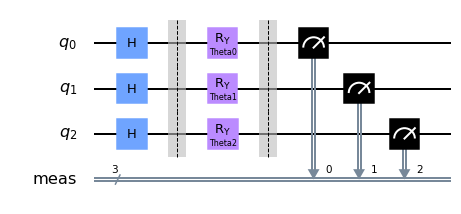

In [5]:
circuit = QuantumCircuit(n_qubits, aerSimulator, n_shots)
print("Expected value for rotation [pi/4]: {}".format(circuit.run(torch.Tensor([np.pi/4]*n_qubits))))
circuit.circuit.draw(output='mpl')

In [6]:
class HybridCircuit(Function):
    
    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QC'):
            ctx.QC = QuantumCircuit(n_qubits, aerSimulator, shots = n_shots)
        
        E = ctx.QC.run(i)
        result = torch.tensor([E])
        ctx.save_for_backward(i, result)
        
        return result
        
    # Calculating gradients for gradient descent during backprop
    @staticmethod
    def backward(ctx, grad_output):
        input_list, EZ = ctx.saved_tensors
        gradients = torch.Tensor()
        
        for i in range(n_qubits):
            shift_right = input_list.detach().clone()
            shift_right[i] = shift_right[i] + shift
            shift_left = input_list.detach().clone()
            shift_left[i] = shift_left[i] - shift
            
            E_right = ctx.QC.run(shift_right)
            E_left = ctx.QC.run(shift_left)
            
            gradient = torch.tensor([E_right]) - torch.tensor([E_left])
            gradients = torch.cat((gradients, gradient.float()))
        
        res = torch.Tensor(gradients)
        result = (res.float() * grad_output.float()).T
        
        return result

<b>Input to the NN:</b><br/>
We provide a 150 samples of images which have labels 0-5, squished into a single tensor. This changes our input from images to real valued (classical) vectors for training. We do the same thing for testing data.<br/>
Also, we take labels for training images to calculate the loss during training and labels for testing images to calculate final accuracy of our model.

In [7]:
n_samples = 100
X_train = datasets.MNIST(root='./data', train=True, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))
idx = np.append(np.where(X_train.targets==0)[0][:n_samples],
                np.where(X_train.targets==1)[0][:n_samples])
idx = np.append(idx, np.where(X_train.targets==2)[0][:n_samples])
idx = np.append(idx, np.where(X_train.targets==3)[0][:n_samples])
idx = np.append(idx, np.where(X_train.targets==4)[0][:n_samples])
idx = np.append(idx, np.where(X_train.targets==5)[0][:n_samples])


X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size = 1, shuffle=True, pin_memory=True)

In [8]:
n_samples = 50
X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])
idx = np.append(idx, np.where(X_test.targets == 2)[0][:n_samples])
idx = np.append(idx, np.where(X_test.targets == 3)[0][:n_samples])
idx = np.append(idx, np.where(X_test.targets == 4)[0][:n_samples])
idx = np.append(idx, np.where(X_test.targets == 5)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

<b>NETWORK:</b>
<p>
Using Pytorch, we design a neural network architecture, with layers compatible with dimensions when we insert quantum layer.
<p>
To begin with, we create a Convolutional Neural Network that has two fully connected layers at the end. The output of the last fully connected layer is fed as parameter $\theta$ to the quantum circuit. The circuit measurements serves as the final prediction for the labels (0, 1, 2, 3, 4 or 5) as provided by $\sigma_z$ measurement.

In [9]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50, n_qubits)
        self.qc = HybridCircuit.apply
        self.oneHot = nn.Linear(n_qubits,1)
        self.fc3 = nn.Linear(1, 3)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1,320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x=self.fc2(x)
        x=np.pi*torch.tanh(x)
        
        MODE = 'QC'
        if MODE == 'QC':
            x = self.qc(x[0])
        else:
            x = self.oneHot(x)
        
        x = torch.sigmoid(x)
        x = torch.cat((x, 1-x), -1)
        return x

    def predict(self, x):
        pred = self.forward(x)
        res = torch.argmax(pred[0]).item()
        return torch.tensor(res)
    
net = NN()
optimizer = optim.Adam(net.parameters(), lr=learningRate)

<b>Training!:</b>
<p>
This training can take up to 40 minutes depending on the hardware used. 
<p>
We have provided a pre-trained model in case you wish to skip the training!

In [11]:
epochs = 30
lossList = []
lossFunc = nn.CrossEntropyLoss()
n_total_steps = len(train_loader)

te = tqdm(range(epochs), desc="Epoch: ")
for epoch in te:
    totalLoss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(data)
        loss = lossFunc(output, target)
        loss.backward()
        optimizer.step()
        te.set_description(f'Training [{(epoch+1)}/{epochs}] Batch [{batch_idx+1}/{n_total_steps}], Loss:{loss.item()}')
        totalLoss.append(loss.item())
    lossList.append(sum(totalLoss)/len(totalLoss))

Training [2/2] Batch [600/600], Loss:2.751639381902322: 100%|████████████████████████████| 2/2 [01:53<00:00, 56.60s/it]


In [13]:
#Save the model! NOTE: This will overwrite a model with the same name!
with open( f'qnn_model_{epochs}_{str(learningRate).split(".")[1]}.pkl', 'wb' ) as f:
    joblib.dump( net, f, compress=3 )

c:\users\carlo\appdata\local\programs\python\python38\lib\site-packages\torch\storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


Text(0, 0.5, 'Cross Entropy Loss')

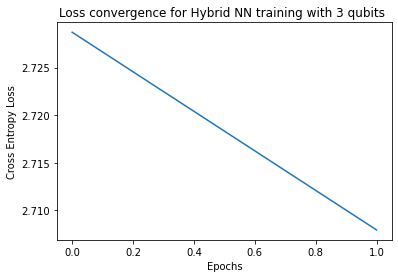

In [14]:
#Print the loss graph!
plt.plot(lossList)
plt.title("Loss convergence for Hybrid NN training with {} qubits ".format(n_qubits))
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")

In [15]:
#Run this block to load the pre-trained model!
with open( 'qnn_model_final.pkl', 'rb' ) as f:
    net = joblib.load( f )

In [17]:
#Testing!
accuracy = 0
count = 0
for batch_idx, (data, target) in enumerate(test_loader):
    count += 1
    output = net.predict(data).item()
    if output == target[0].item():
        accuracy+= 1
        
print("Accuracy: {}%".format(accuracy/count * 100))

Accuracy: 90.33333333333333%


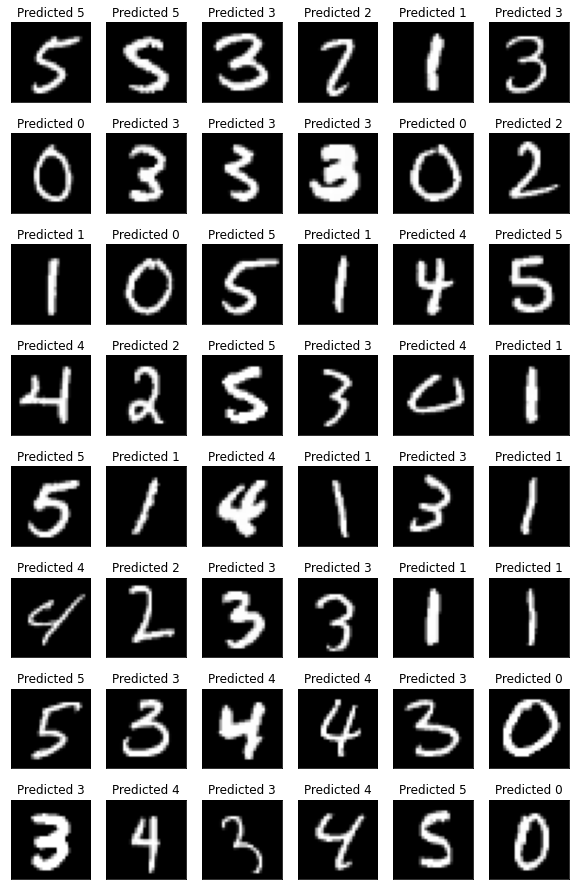

In [18]:
#Test Visualization
n_samples_shape = (8,6)
count = 0
fig, axes = plt.subplots(nrows=n_samples_shape[0], ncols=n_samples_shape[1], figsize=(10,2*n_samples_shape[0]))

net.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_shape[0]*n_samples_shape[1]:
            break
        pred = net.predict(data).item()

        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].imshow(data[0].numpy().squeeze(), cmap='gray')
        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_xticks([])
        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_yticks([])
        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_title('Predicted {}'.format(pred))
        
        count += 1